In [1]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-scv8qa5l
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-scv8qa5l
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.1 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=5509b8c4d9ec31038724a7977576f0e220499673743b38d8a8dabe64f2fc8c42
  Stored in directory: /tmp/pip-ephem-wheel-cache-q9kmhjkd/wheels/35/3e/df/3d24cbfb3b6a06f17a2bfd7d1138900d4365d9028aa8f6e92f
Successfully built clip


In [37]:
import os
import torch
import clip
from PIL import Image
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from IPython.display import display, Image as IPImage
import json

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)
print("Model loaded on", device)

Model loaded on cpu


In [39]:
artifact_folder = "/content/artifacts"
market_folder = "/content/marketplace"
metadata_file = "/content/marketplace_data.json"

In [40]:
with open(metadata_file, 'r') as f:
    marketplace_data = json.load(f)

In [46]:
# --- Load artifact images ---
artifact_image_paths = [os.path.join(artifact_folder, f)
                        for f in os.listdir(artifact_folder) if f.endswith((".png", ".jpg", ".jpeg"))]

artifact_embs = []
for path in artifact_image_paths:
    img = preprocess(Image.open(path)).unsqueeze(0).to(device)
    with torch.no_grad():
        emb = model.encode_image(img)
        emb /= emb.norm(dim=-1, keepdim=True)
        artifact_embs.append(emb.cpu().numpy())

In [52]:
# --- Load artifact images and compute embeddings ---
artifact_image_paths = [os.path.join(artifact_folder, f)
                        for f in os.listdir(artifact_folder) if f.endswith((".png", ".jpg", ".jpeg"))]

artifact_embs_list = []

for path in artifact_image_paths:
    img = preprocess(Image.open(path)).unsqueeze(0).to(device)
    with torch.no_grad():
        emb = model.encode_image(img)
        emb /= emb.norm(dim=-1, keepdim=True)
        artifact_embs_list.append(emb)

# Average embeddings across multiple images
artifact_emb = torch.mean(torch.cat(artifact_embs_list, dim=0), dim=0, keepdim=True)

# --- Predict artifact type using CLIP text prompts ---
categories = [
    "Coloured palm fronds (Safeefah palm leaf weaving)",      # mats, wall hangings
    "Traditional rug",                           # handwoven rugs
    "Palm frond fan",                            # hand fans made from palm leaves
    "Decorative lantern",                        # traditional lanterns
    "Emirati jewelry box",                        # small handcrafted boxes
    "Wooden carving",                            # carved wooden artifacts
    "Ceramic vase",                              # painted or decorative pottery
    "Handmade doll",                             # traditional dolls
    "Textile embroidery",                        # hand-stitched fabrics
    "Decorative plate",                           # engraved or painted plates
]

text_inputs = clip.tokenize(categories).to(device)

with torch.no_grad():
    text_emb = model.encode_text(text_inputs)
    text_emb /= text_emb.norm(dim=-1, keepdim=True)

    sims_text = artifact_emb @ text_emb.T  # all tensors, no numpy needed
    pred_idx = sims_text.argmax().item()
    predicted_type = categories[pred_idx]

print(f"Predicted artifact type: {predicted_type}\n")

Predicted artifact type: Coloured palm fronds (Safeefah palm leaf weaving)



🔍 Top visually similar marketplace products:

Artifact Type: Coloured palm fronds (Khoos weaving)
Artisan: Umm Ali — Emirati craftswoman
Price: AED 150
Location: Sharjah Heritage Souq
Description: Handwoven decorative pieces made from dyed palm fronds using the traditional Khoos technique, representing Emirati heritage craftsmanship.


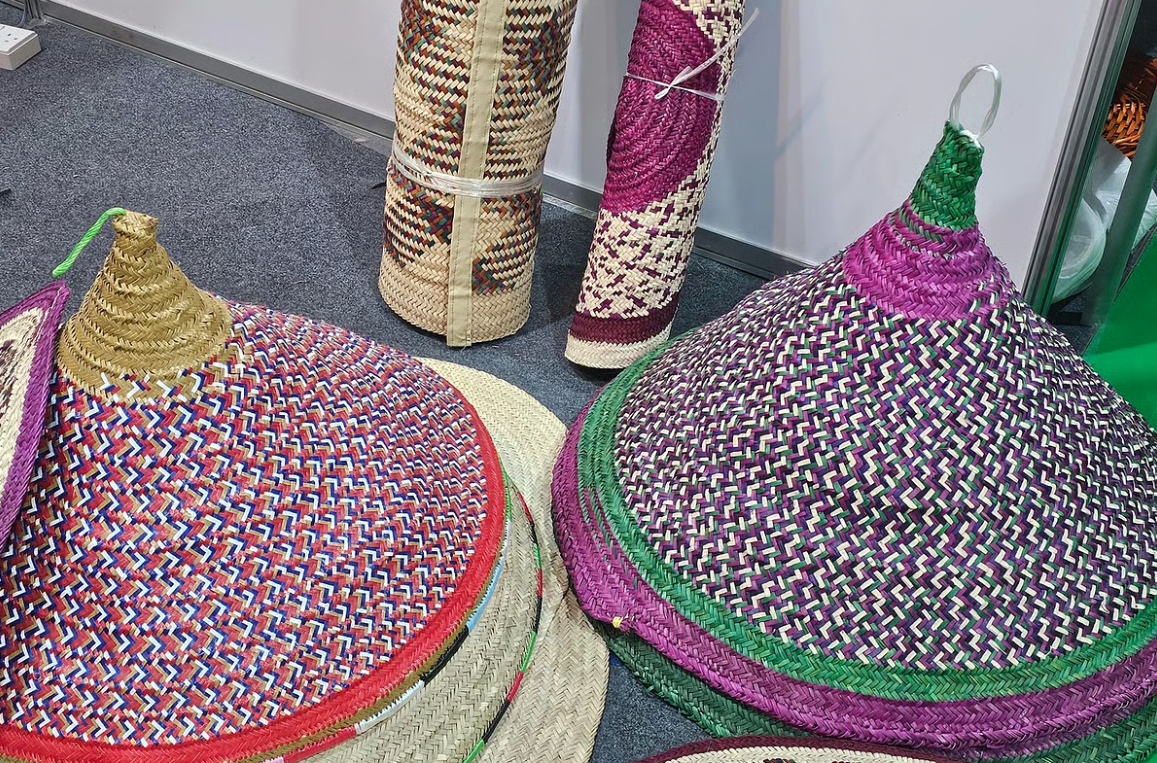

------------------------------------------------------------
Artifact Type: Safeefah (palm-leaf mat)
Artisan: Fatima Al Kaabi
Price: AED 200
Location: Dubai Craft Market
Description: Traditional flat mat woven with dyed palm fronds in geometric patterns, used in Emirati households for seating and dining.


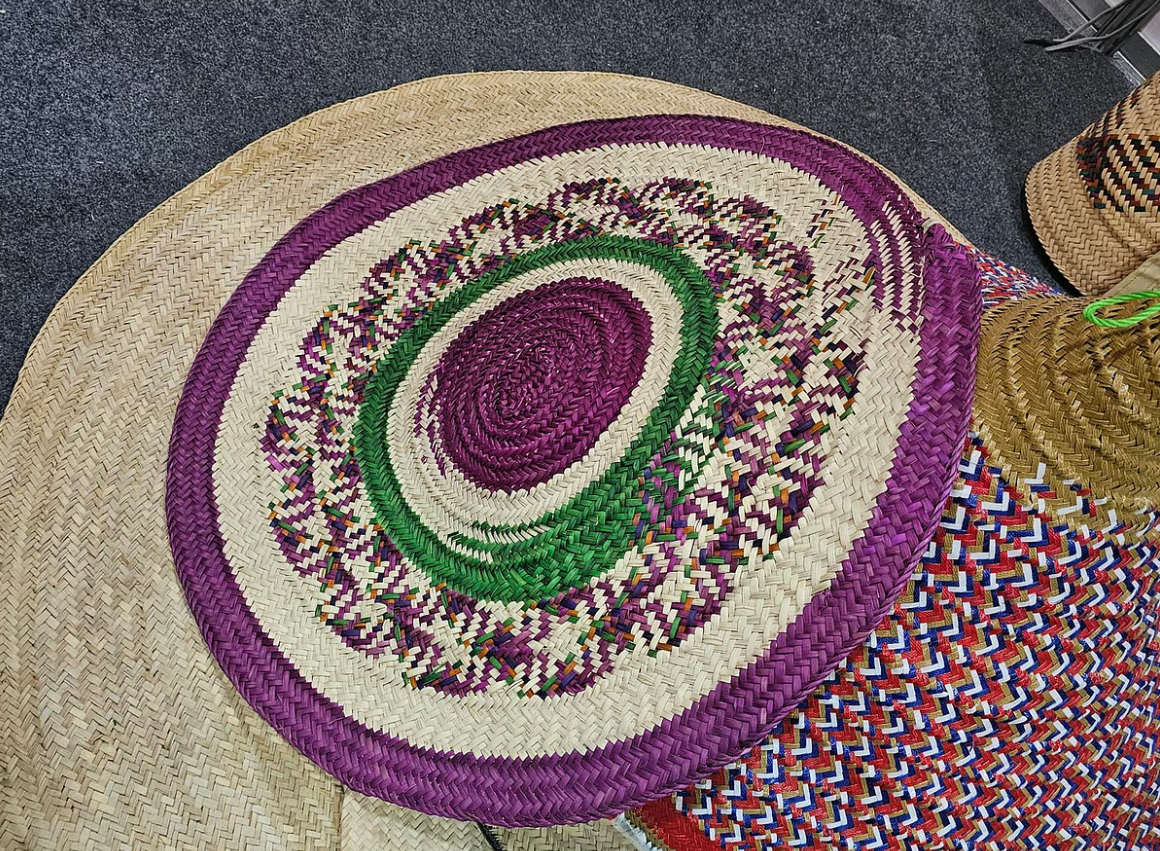

------------------------------------------------------------


In [53]:
# --- Encode marketplace images for similarity search ---
market_paths = [os.path.join(market_folder, d["image"].split('/')[-1]) for d in marketplace_data]
market_embs_list = []

for path in market_paths:
    img = preprocess(Image.open(path)).unsqueeze(0).to(device)
    with torch.no_grad():
        emb = model.encode_image(img)
        emb /= emb.norm(dim=-1, keepdim=True)
        market_embs_list.append(emb.cpu().numpy())
market_embs = np.vstack(market_embs_list)

# --- Find top visually similar marketplace products ---
sims_img = cosine_similarity(artifact_emb.cpu().numpy(), market_embs)
top_idx = sims_img[0].argsort()[-3:][::-1]  # Top 3 matches

print("🔍 Top visually similar marketplace products:\n")
for i in top_idx:
    data = marketplace_data[i]
    print(f"Artifact Type: {data.get('artifact_type', 'N/A')}")
    print(f"Artisan: {data.get('artisan', 'N/A')}")
    print(f"Price: {data.get('price', 'N/A')}")
    print(f"Location: {data.get('location', 'N/A')}")
    print(f"Description: {data.get('description', 'N/A')}")
    display(IPImage(filename=market_paths[i]))
    print("-" * 60)